# 6. L1 Regularization for GP

In [137]:
import numpy as np
import pandas as pd
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from gpflow.config import default_float
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Generating Data

In [138]:
def sim_sparse_data(n=400, m=5, beta=None, sigma=0.5, seed=22):
    np.random.seed(seed)
    X = np.random.randn(n, m)
    if beta is None:
        beta = np.array([1.5, 0, 0, -2.0, 0]) if m >= 5 else np.zeros(m)
    noise = np.random.normal(0, sigma, n)
    y = X @ beta + noise
    return X, y.reshape(-1,1), beta

In [139]:
def sim_complex_sparse_data(n=400, m=7, beta=None, sigma=0.5, seed=22):
    np.random.seed(seed)
    
    X = np.random.randn(n, m)
    
    # Define a beta vector with strong and weak signals
    if beta is None:
        beta = np.zeros(m)
        beta[0] = 1.5   # strong positive
        beta[2] = -2.0  # strong negative
        beta[4] = 0.7   # weak positive
        beta[6] = -0.5  # weak negative

    # Linear component
    linear_term = X @ beta


    # Add Gaussian noise
    noise = np.random.normal(0, sigma, n)

    # Final output
    y = linear_term + noise

    return X, y.reshape(-1, 1), beta

In [140]:
X, y, beta = sim_sparse_data()
X, y, beta = sim_complex_sparse_data()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 22)
ytrain.reshape(-1,1)
ytest.reshape(-1,1)

m = X.shape[1]

## Method 1: Training Twice

### Original GP

In [141]:
kernel = gpf.kernels.Matern52()
likelihood = gpf.likelihoods.Gaussian()

A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

base_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

opt = gpf.optimizers.Scipy()
opt.minimize(base_mod.training_loss, base_mod.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 213.87023959893844
        x: [ 1.862e+01 -2.075e+01 -1.388e+00  1.544e+00 -2.280e-02
            -2.031e+00 -5.669e-02  7.081e-01 -2.323e-02 -5.524e-01
            -1.695e-03]
      nit: 41
      jac: [ 1.881e-10  6.958e-07 -5.684e-03 -9.644e-03 -2.753e-03
             3.954e-03  1.840e-03 -3.997e-04 -4.928e-03  3.155e-03
             3.487e-03]
     nfev: 50
     njev: 50
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>

In [142]:
log_likelihood = base_mod.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_likelihood:.3f}")
print("Linear coefficients (A):", base_mod.mean_function.A.numpy().flatten())
print("Bias (b):", base_mod.mean_function.b.numpy())

Log Marginal Likelihood: -213.870
Linear coefficients (A): [ 1.54360748 -0.02280489 -2.03107436 -0.05668718  0.70813113 -0.0232291
 -0.55241546]
Bias (b): [-0.00169506]


In [143]:
y_mean_base_mod, y_var_base_mod = base_mod.predict_y(Xtest)
rmse = mean_squared_error(ytest, y_mean_base_mod, squared=False)
print(f'RMSE Base Mod: {rmse:.3f}')

RMSE Base Mod: 0.468


### GP With Penalty Term Added to Likelihood

In [144]:
# define model
l1_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

In [145]:
lambda_val = 30

def training_loss_lasso(model, lambda_val = lambda_val):
    base_loss = model.training_loss()
    l1_penalty = lambda_val * tf.reduce_sum(tf.abs(model.mean_function.A))
    total_loss = base_loss + l1_penalty
    return total_loss

opt = gpf.optimizers.Scipy()
opt.minimize(
    lambda: training_loss_lasso(l1_mod, lambda_val), 
    l1_mod.trainable_variables
)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 359.8412759076441
        x: [ 1.862e+01 -2.075e+01 -1.373e+00  1.525e+00 -1.812e-03
            -2.013e+00 -3.659e-02  6.857e-01 -1.753e-07 -5.318e-01
            -2.283e-03]
      nit: 17
      jac: [ 1.455e-09  6.734e-07 -4.965e-05 -4.893e-05  4.092e-04
             1.717e-05  2.371e-04 -1.315e-05 -1.669e+00  1.011e-04
            -6.516e-05]
     nfev: 65
     njev: 65
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>

In [146]:
# print results
log_likelihood = l1_mod.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_likelihood:.3f}")
coefficients = l1_mod.mean_function.A.numpy().flatten()
print(f"Linear coefficients (A):\n{coefficients}")
print("Bias (b):", l1_mod.mean_function.b.numpy())

Log Marginal Likelihood: -216.028
Linear coefficients (A):
[ 1.52458197e+00 -1.81188213e-03 -2.01323385e+00 -3.65882497e-02
  6.85730358e-01 -1.75321700e-07 -5.31825802e-01]
Bias (b): [-0.00228327]


In [162]:
y_mean_l1_mod, y_var_l1_mod = l1_mod.predict_y(Xtest)
rmse = mean_squared_error(ytest, y_mean_l1_mod, squared=False)
print(f'RMSE L1 Mod: {rmse:.3f}')

RMSE L1 Mod: 0.466


### Retraining on Selected Features

In [147]:
def threshold_coef(threshold = 0.1, coefficients = coefficients):
    n = len(coefficients)

    reduced_coef = np.zeros(n)
    for i in range(n):
        if np.abs(coefficients[i]) < threshold:
            reduced_coef[i] = 0
        else:
            reduced_coef[i] = coefficients[i]
        
    result = tf.convert_to_tensor(reduced_coef, dtype=tf.float64)
    result = tf.reshape(result, (n, 1))
    return result

reduced_coef = threshold_coef()

In [148]:
def select_features(threshold = 0.1, coefficients = coefficients):
    indicator = np.where(threshold_coef(threshold, coefficients) != 0, 1,0)
    return indicator.flatten()

In [149]:
mask = select_features(0.1, coefficients) == 1
Xtrain_reduced = Xtrain[:, mask]
Xtest_reduced = Xtest[:, mask]

A_init_reduced = A_init[mask]

reduced_mod = gpf.models.GPR(
    data=(Xtrain_reduced, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = gpf.functions.Linear(A=A_init_reduced, b = b_init) 
    )

opt = gpf.optimizers.Scipy()
opt.minimize(
    #lambda: training_loss_lasso(reduced_mod, lambda_val), 
    reduced_mod.training_loss,
    reduced_mod.trainable_variables
)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 216.59799446471632
        x: [ 1.862e+01 -2.075e+01 -1.369e+00  1.544e+00 -2.034e+00
             7.114e-01 -5.527e-01 -1.014e-03]
      nit: 17
      jac: [ 1.622e-10  6.841e-07  9.480e-05  3.309e-04  7.304e-05
            -3.982e-04  8.245e-05 -1.499e-04]
     nfev: 20
     njev: 20
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [150]:
# print results
log_likelihood = reduced_mod.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_likelihood:.3f}")
optimized_A = reduced_mod.mean_function.A.numpy().flatten()
print(f"Linear coefficients (A):\n{optimized_A}")
print("Bias (b):", reduced_mod.mean_function.b.numpy())

Log Marginal Likelihood: -216.598
Linear coefficients (A):
[ 1.54378617 -2.03395319  0.71142676 -0.55267706]
Bias (b): [-0.00101442]


In [151]:

y_mean_red_mod, y_var_red_mod = reduced_mod.predict_y(Xtest_reduced)
rmse = mean_squared_error(ytest, y_mean_red_mod, squared=False)
print(f'RMSE Reduced Mod: {rmse:.3f}')

RMSE Reduced Mod: 0.476


## Method 2: Alternating Optimization

In [152]:
# write a new class to add lambda parameter
class GPWithLambda(gpf.models.GPR):
    def __init__(self, data, kernel, mean_function, likelihood=None):
        super().__init__(data=data, kernel=kernel, mean_function=mean_function, likelihood=likelihood)
        self.lbda_val = gpf.Parameter(1.0, transform=gpf.utilities.positive())

    def training_loss_l1(self):
        base_loss = super().training_loss()
        l1_penalty = self.lbda_val * tf.reduce_sum(tf.abs(self.mean_function.A))
        return base_loss + l1_penalty

In [153]:
alt_mod = GPWithLambda(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = gpf.functions.Linear(A=A_init, b = b_init))

alt_mod

name,class,transform,prior,trainable,shape,dtype,value
GPWithLambda.mean_function.A,Parameter,Identity,,True,"(7, 1)",float64,[[0....
GPWithLambda.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPWithLambda.kernel.variance,Parameter,Softplus,,True,(),float64,9.70476056782205e-10
GPWithLambda.kernel.lengthscales,Parameter,Softplus,,True,(),float64,18.61641
GPWithLambda.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.22669745703680666
GPWithLambda.lbda_val,Parameter,Softplus,,True,(),float64,1.0


In [154]:
count = 0
delta = 3
tol = 1e-6

loss1_history = []
loss2_history = []
delta_history = []
lambda_history = []

lambda_old = alt_mod.lbda_val.numpy()

step1_loss = 0
step0_loss = 0


while True:
    
    count += 1
    if np.abs(delta) <= tol:
        print(f'Converged on iteration {count-1}')
        print(f'Loss: {step2_loss}')
        break
    
    ## STEP 1

    # optimize using l1 regularization
    gpf.set_trainable(alt_mod.mean_function.A, True)
    gpf.set_trainable(alt_mod.mean_function.b, True)
    gpf.set_trainable(alt_mod.lbda_val, False)
    gpf.set_trainable(alt_mod.kernel, False)

    opt.minimize(
        alt_mod.training_loss_l1, 
        alt_mod.trainable_variables)
    step1_loss = alt_mod.log_marginal_likelihood().numpy()

    ## STEP 2

    # freeze Betas and xcvfbnm,....................................................................................................................................................................................................................................
    gpf.set_trainable(alt_mod.mean_function.A, False)
    gpf.set_trainable(alt_mod.mean_function.b, False)
    gpf.set_trainable(alt_mod.lbda_val, True)
    gpf.set_trainable(alt_mod.kernel, True)

    # optimize using non-penalized loss
    opt.minimize(
        alt_mod.training_loss_l1,
        alt_mod.trainable_variables)
    
    step2_loss = alt_mod.log_marginal_likelihood().numpy()
    
    lambda_new = alt_mod.lbda_val.numpy()
    delta = np.abs(step1_loss - step2_loss)
    lambda_old = lambda_new 

    ## RESULTS

    delta = np.abs(step1_loss - step2_loss)

    print(f'Delta {count}: {delta}')
    print(f'Lambda {count}: {lambda_new}')

    loss1_history.append(-step1_loss)
    loss2_history.append(-step2_loss)
    delta_history.append(delta)
    lambda_history.append(lambda_new)

Delta 1: 1.2995542419957928e-09
Lambda 1: 5.6418600566772414e-05
Converged on iteration 1
Loss: -213.8726324343715


In [155]:
y_mean_alt_mod, y_var_alt_mod = alt_mod.predict_y(Xtest)
rmse = mean_squared_error(ytest, y_mean_alt_mod, squared=False)
print(f'RMSE Alternating Mod: {rmse:.3f}')

RMSE Alternating Mod: 0.468


In [160]:
alt_mod.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-213.8726324343715>

Here, when optiimizng, reducing lambda will always decrease the penalty term, so the model is basically freeing itself from regularization. This approach of alternating optimization won't work if lambda is allowed to do this. 

In [156]:
alt_mod

name,class,transform,prior,trainable,shape,dtype,value
GPWithLambda.mean_function.A,Parameter,Identity,,False,"(7, 1)",float64,[[1.54299...
GPWithLambda.mean_function.b,Parameter,Identity,,False,"(1,)",float64,[-0.0017165]
GPWithLambda.kernel.variance,Parameter,Softplus,,True,(),float64,9.671686498626976e-10
GPWithLambda.kernel.lengthscales,Parameter,Softplus,,True,(),float64,18.61641
GPWithLambda.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.22287006848164911
GPWithLambda.lbda_val,Parameter,Softplus,,True,(),float64,5.6418600566772414e-05


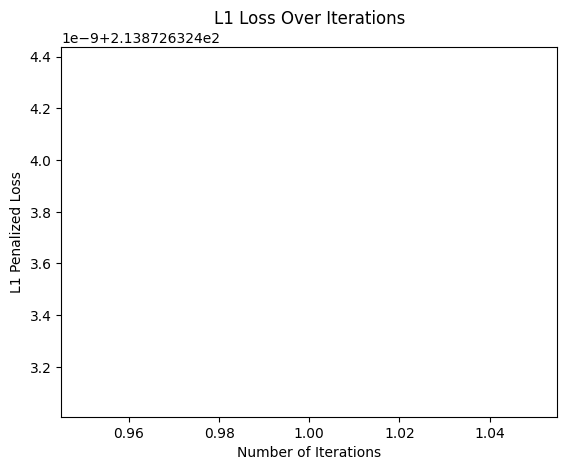

In [161]:
iterations = list(range(1, len(loss1_history) + 1))

plt.plot(iterations, loss1_history, label = "Step 1")
plt.plot(iterations, loss2_history, label = "Step 2")
plt.legend
plt.xlabel('Number of Iterations')
plt.ylabel('L1 Penalized Loss')
plt.title('L1 Loss Over Iterations')
plt.show()


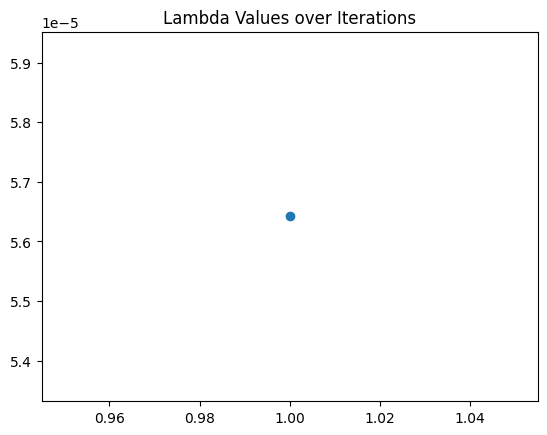

In [158]:
plt.plot(iterations, lambda_history, label = 'Lambda value', marker='o')
plt.title('Lambda Values over Iterations')
plt.show()